In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import folium
import openrouteservice as ors
from folium import plugins
import os

In [2]:
ruta_base = os.getcwd()

In [3]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'La Paz, Baja California Sur',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]

In [4]:
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

In [5]:
np.random.seed(42)

In [6]:
COSTO_COMBUSTIBLE = 23.96
RENDIMIENTO_AUTO = 20.69
VALOR_HORA = 35

In [7]:
distancias = pd.read_csv("../costos/tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("../costos/tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_excel("../costos/peajes.xlsx", index_col=0)  # Tabla de costos de peajes (MXN)

In [8]:
def convertir_a_minutos(tiempo):
    if pd.isna(tiempo):
        return np.nan
    horas, minutos = map(int, str(tiempo).split(':'))
    return horas * 60 + minutos

tiempos_minutos = tiempos.map(convertir_a_minutos)

print("Tiempos convertidos a minutos satisfactoriamente.")

Tiempos convertidos a minutos satisfactoriamente.


In [9]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [10]:
matriz_costos = pd.read_excel("matriz_costos.xlsx", index_col=0)
ciudades = matriz_costos.index

In [11]:
np.random.seed(42)

def calcular_costo(ruta, matriz_costos):
    costo_total = 0
    for i in range(len(ruta) - 1):
        costo_total += matriz_costos[ruta[i]][ruta[i + 1]]
    costo_total += matriz_costos[ruta[-1]][ruta[0]] 
    return costo_total

def crear_poblacion(ciudades, tam_poblacion):
    return [random.sample(ciudades, len(ciudades)) for _ in range(tam_poblacion)]

def seleccion(poblacion, costos, k=3):
    seleccionados = random.sample(range(len(poblacion)), k)
    mejor = min(seleccionados, key=lambda i: costos[i])
    return poblacion[mejor]

def cruce(padre1, padre2):
    size = len(padre1)
    inicio, fin = sorted(random.sample(range(size), 2))
    hijo = [None] * size
    hijo[inicio:fin] = padre1[inicio:fin]
    puntero = 0
    for gene in padre2:
        if gene not in hijo:
            while hijo[puntero] is not None:
                puntero += 1
            hijo[puntero] = gene
    return hijo

def mutacion(ruta, tasa_mutacion):
    if random.random() < tasa_mutacion:
        i, j = random.sample(range(len(ruta)), 2)
        ruta[i], ruta[j] = ruta[j], ruta[i]

def algoritmo_genetico(matriz_costos, ciudades, generaciones, tam_poblacion, tasa_mutacion):
    poblacion = crear_poblacion(ciudades, tam_poblacion)
    mejores_costos = []
    mejor_ruta_global = None
    mejor_costo_global = float("inf")
    
    for _ in range(generaciones):
        costos = [calcular_costo(ruta, matriz_costos) for ruta in poblacion]
        nueva_poblacion = []
        
        for _ in range(tam_poblacion // 2):
            padre1 = seleccion(poblacion, costos)
            padre2 = seleccion(poblacion, costos)
            hijo1 = cruce(padre1, padre2)
            hijo2 = cruce(padre2, padre1)
            mutacion(hijo1, tasa_mutacion)
            mutacion(hijo2, tasa_mutacion)
            nueva_poblacion.extend([hijo1, hijo2])
        
        poblacion = nueva_poblacion
        mejor_costo_local = min(costos)
        mejor_ruta_local = poblacion[costos.index(mejor_costo_local)]
        
        if mejor_costo_local < mejor_costo_global:
            mejor_costo_global = mejor_costo_local
            mejor_ruta_global = mejor_ruta_local
        
        mejores_costos.append(mejor_costo_global)
    
    return mejor_ruta_global, mejor_costo_global, mejores_costos

In [12]:
np.random.seed(42)

def calcular_costo(ruta, matriz_costos):
    costo_total = 0
    for i in range(len(ruta) - 1):
        costo_total += matriz_costos[ruta[i]][ruta[i + 1]]
    costo_total += matriz_costos[ruta[-1]][ruta[0]]  # Costo de volver al inicio
    return costo_total

def crear_poblacion(ciudades, tam_poblacion):
    return [random.sample(ciudades, len(ciudades)) for _ in range(tam_poblacion)]

def seleccion(poblacion, costos, k=3):
    seleccionados = random.sample(range(len(poblacion)), k)
    mejor = min(seleccionados, key=lambda i: costos[i])
    return poblacion[mejor]

def cruce(padre1, padre2):
    size = len(padre1)
    inicio, fin = sorted(random.sample(range(size), 2))
    hijo = [None] * size
    hijo[inicio:fin] = padre1[inicio:fin]
    puntero = 0
    for gene in padre2:
        if gene not in hijo:
            while hijo[puntero] is not None:
                puntero += 1
            hijo[puntero] = gene
    return hijo

def mutacion(ruta, tasa_mutacion):
    if random.random() < tasa_mutacion:
        i, j = random.sample(range(len(ruta)), 2)
        ruta[i], ruta[j] = ruta[j], ruta[i]

def algoritmo_genetico(matriz_costos, ciudades, generaciones, tam_poblacion, tasa_mutacion):
    poblacion = crear_poblacion(ciudades, tam_poblacion)
    mejores_costos = []
    mejor_ruta_global = None
    mejor_costo_global = float("inf")
    
    for _ in range(generaciones):
        costos = [calcular_costo(ruta, matriz_costos) for ruta in poblacion]
        nueva_poblacion = []
        
        for _ in range(tam_poblacion // 2):
            padre1 = seleccion(poblacion, costos)
            padre2 = seleccion(poblacion, costos)
            hijo1 = cruce(padre1, padre2)
            hijo2 = cruce(padre2, padre1)
            mutacion(hijo1, tasa_mutacion)
            mutacion(hijo2, tasa_mutacion)
            nueva_poblacion.extend([hijo1, hijo2])
        
        poblacion = nueva_poblacion
        mejor_costo_local = min(costos)
        mejor_ruta_local = poblacion[costos.index(mejor_costo_local)]
        
        if mejor_costo_local < mejor_costo_global:
            mejor_costo_global = mejor_costo_local
            mejor_ruta_global = mejor_ruta_local
        
        mejores_costos.append(mejor_costo_global)
    
    # Agregar el punto inicial al final de la ruta
    mejor_ruta_global = mejor_ruta_global + [mejor_ruta_global[0]]
    
    return mejor_ruta_global, mejor_costo_global, mejores_costos

# Ejecutar el algoritmo genético
GENERACIONES = 500
POBLACION = 150
MUTACION = 0.1
ciudades = list(coordenadas.keys())

mejor_ruta, mejor_costo_ga, evolucion_costos = algoritmo_genetico(
    matriz_costos, ciudades, GENERACIONES, POBLACION, MUTACION
)

print("Mejor ruta encontrada por GA:", mejor_ruta)
print("Costo total:", mejor_costo_ga)

Mejor ruta encontrada por GA: ['Chetumal', 'Mérida', 'San Francisco de Campeche', 'Villahermosa', 'Tuxtla Gutiérrez', 'Oaxaca de Juárez', 'Cuernavaca', 'Heroica Puebla de Zaragoza', 'Tlaxcala de Xicohténcatl', 'Chilpancingo de los Bravo', 'CDMX', 'Pachuca de Soto', 'Ciudad Victoria', 'Monterrey', 'Saltillo', 'Zacatecas', 'San Luis Potosí', 'Santiago de Querétaro', 'Toluca de Lerdo', 'Morelia', 'Guadalajara', 'Guanajuato', 'Aguascalientes', 'Colima', 'Tepic', 'Culiacán Rosales', 'La Paz', 'Mexicali', 'Hermosillo', 'Chihuahua', 'Victoria de Durango', 'Xalapa-Enríquez', 'Chetumal']
Costo total: 32416.737433542774


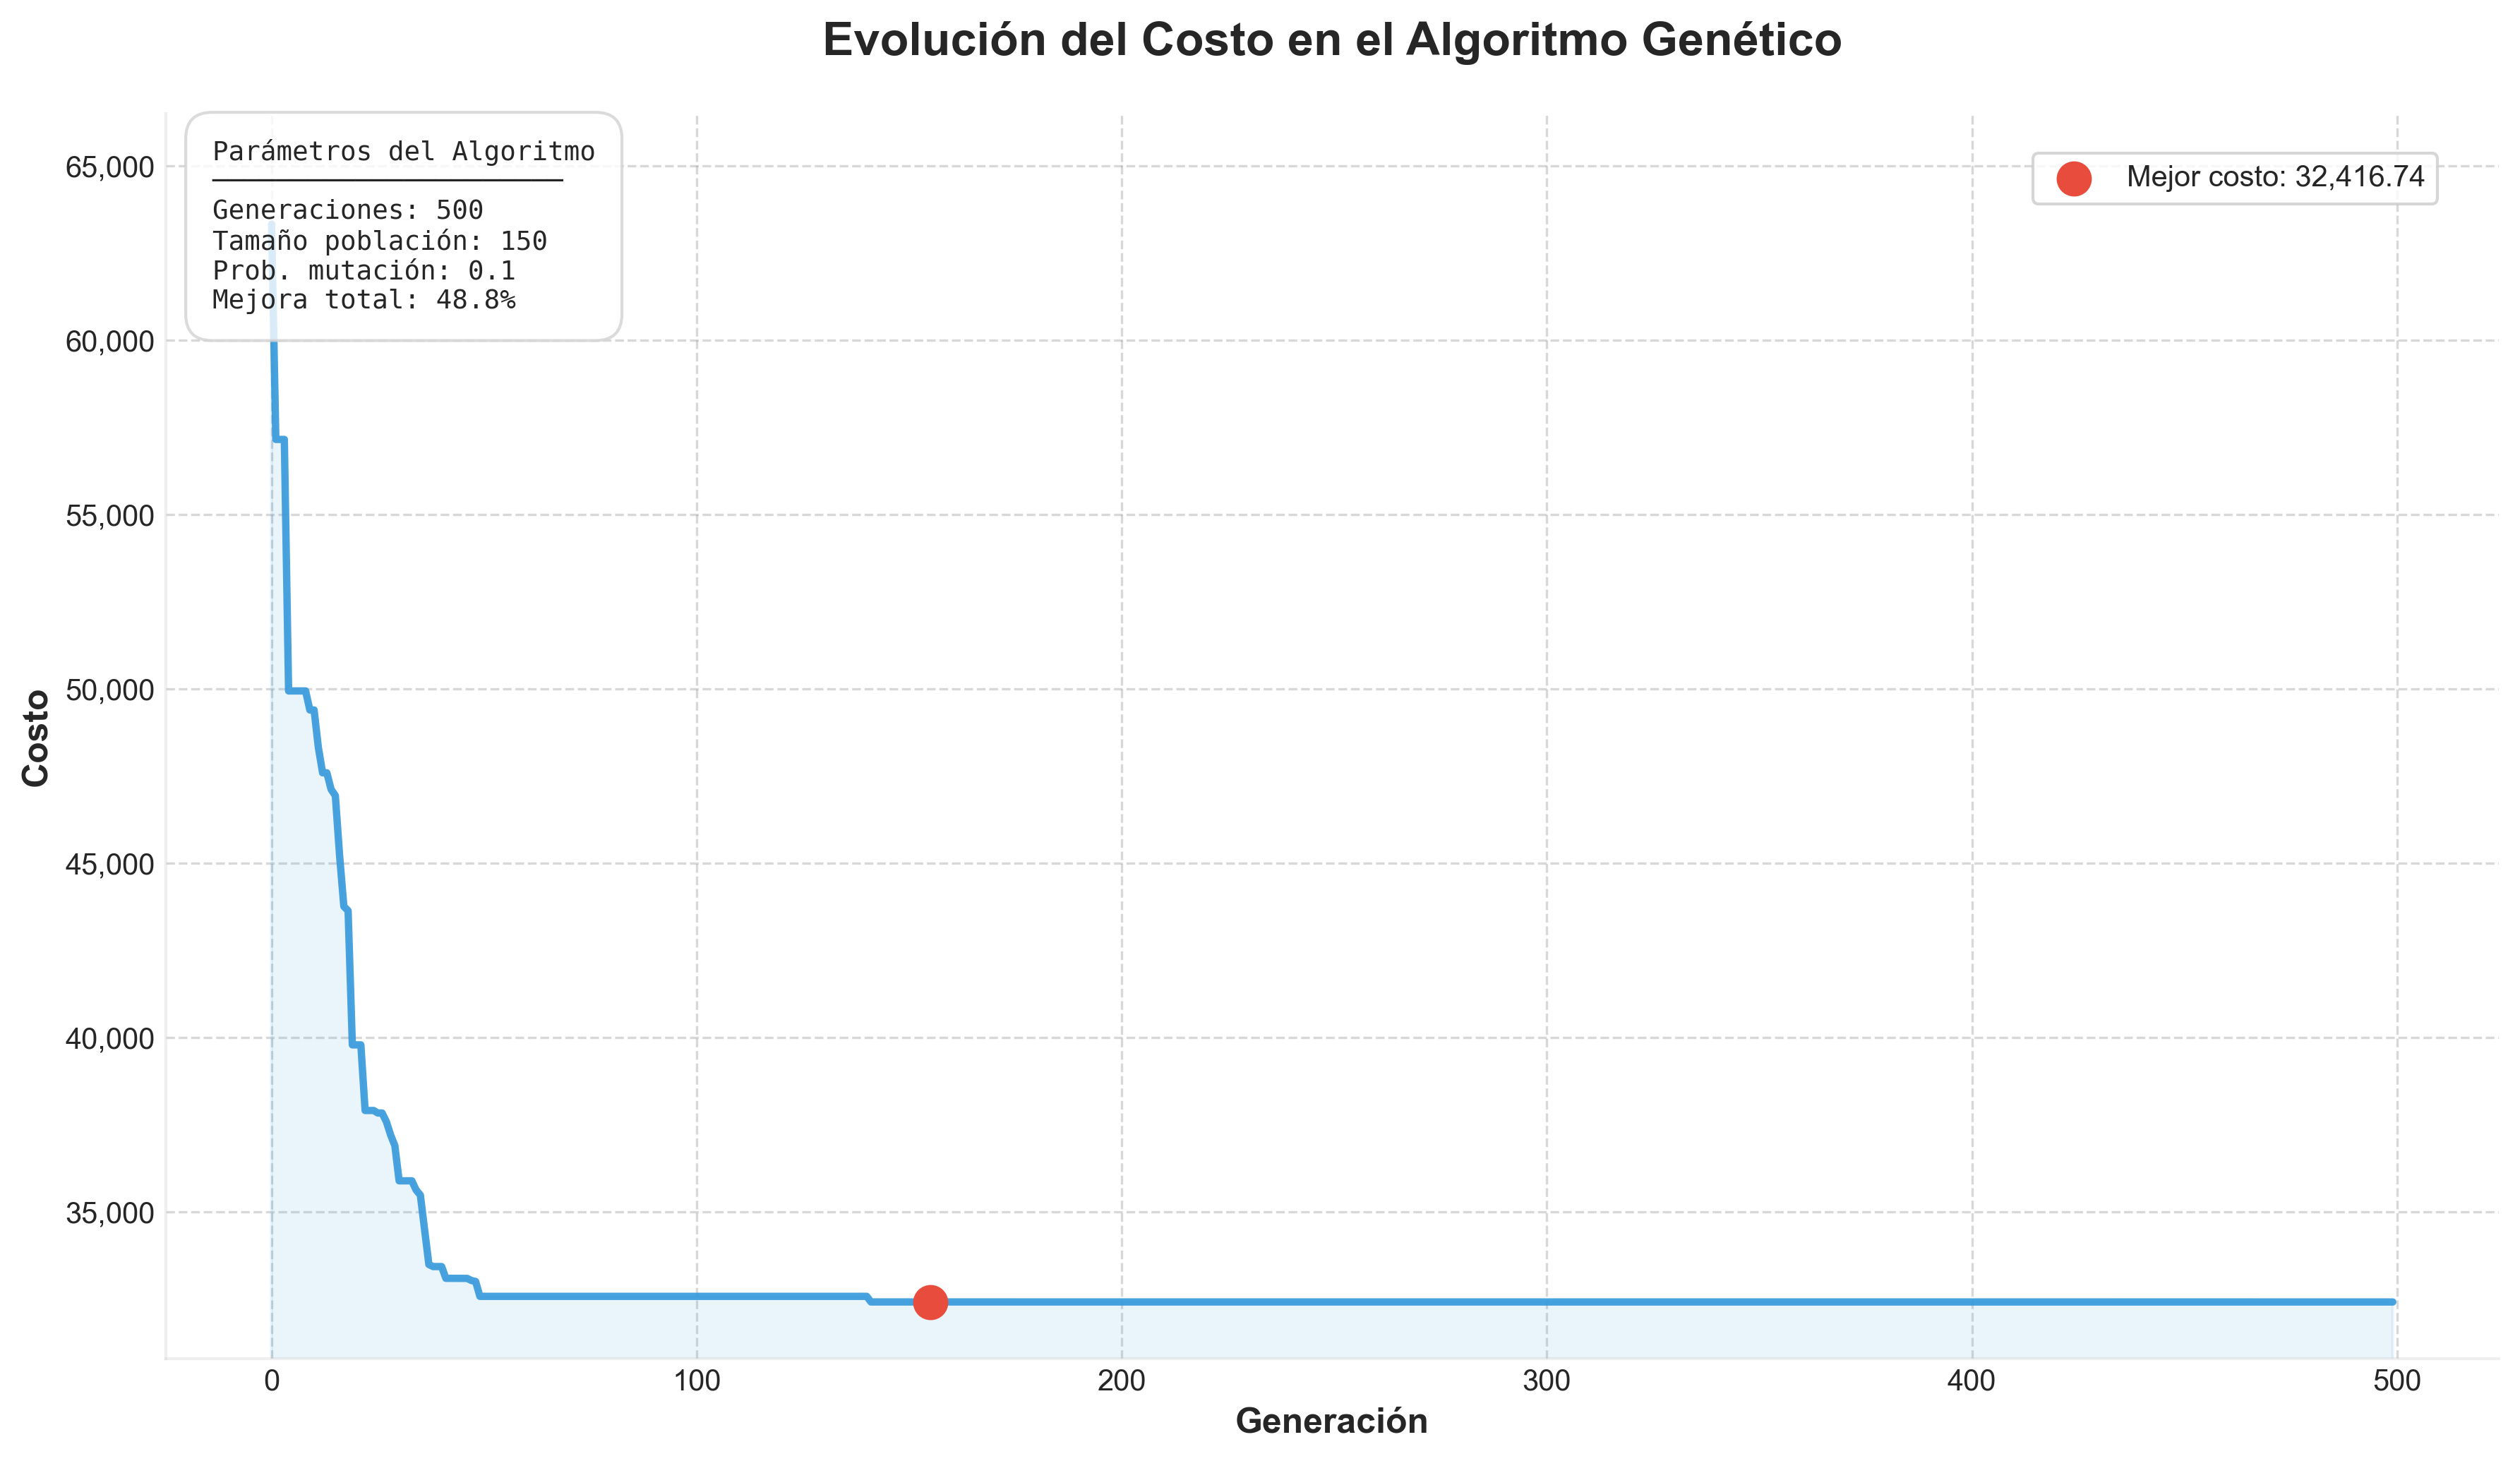

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ga_evolution(evolucion_costos, mejor_costo_ga, num_generaciones, tamano_poblacion, prob_mutacion):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos para la gráfica
    iterations = np.arange(len(evolucion_costos))
    
    # Crear el gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, evolucion_costos, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Añadir área sombreada bajo la curva
    ax.fill_between(iterations, 
                   evolucion_costos, 
                   color=main_color, 
                   alpha=0.1)
    
    # Encontrar la generación donde se encontró el mejor costo
    idx_mejor_costo = evolucion_costos.index(min(evolucion_costos))
    
    # Marcar el mejor costo
    ax.scatter(idx_mejor_costo, 
              mejor_costo_ga,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo_ga:,.2f}')
    
    # Personalizar el grid
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configurar los ejes
    ax.set_xlabel('Generación', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar los bordes del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Formatear los números del eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajustar los límites del eje Y
    ymin = min(evolucion_costos) * 0.95
    ymax = max(evolucion_costos) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título principal
    plt.title('Evolución del Costo en el Algoritmo Genético', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Crear cuadro de texto para los parámetros
    mejora_total = ((evolucion_costos[0] - mejor_costo_ga) / evolucion_costos[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Generaciones: {num_generaciones}\n'
        f'Tamaño población: {tamano_poblacion}\n'
        f'Prob. mutación: {prob_mutacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir el cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    # Guardar con alta calidad
    plt.savefig('evolucion_costos_ga_all.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Para usar la función:
plot_ga_evolution(
    evolucion_costos,
    mejor_costo_ga,
    num_generaciones=GENERACIONES,  # Reemplazar con tu valor
    tamano_poblacion=POBLACION,  # Reemplazar con tu valor
    prob_mutacion=MUTACION      # Reemplazar con tu valor
)

In [14]:
import folium
from IPython.display import display

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Dibujar líneas entre las ciudades
for i in range(len(coordenadas_ruta) - 1):
    puntos = [coordenadas_ruta[i], coordenadas_ruta[i + 1]]
    folium.PolyLine(
        puntos,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(mapa)

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(
            location=(lat, lon),
            popup=f"Inicio/Final: {mejor_ruta[i]}", 
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(
            location=(lat, lon),
            popup=f"Penúltima parada: {mejor_ruta[i]}", 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(
            location=(lat, lon),
            popup=f"Intermedia: {mejor_ruta[i]}", 
            icon=folium.Icon(color="blue")
        ).add_to(mapa)
        

# Construir la ruta relativa para guardar el archivo
ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_ga.html"))

# Crear las carpetas necesarias si no existen
os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

# Guardar el archivo HTML
mapa.save(ruta_guardar)

# Mostrar el mapa en la visualización
display(mapa)

In [15]:
import openrouteservice
import folium
from IPython.display import display

# Crear cliente de Open Route Service
api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
client = openrouteservice.Client(key=api_key)

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Dividir la ruta en segmentos
segmentos = [(coordenadas_ruta[i], coordenadas_ruta[i + 1]) for i in range(len(coordenadas_ruta) - 1)]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Obtener y graficar cada segmento
for inicio, fin in segmentos:
    try:
        # Solicitar la ruta para el segmento actual
        route = client.directions(
            coordinates=[(inicio[1], inicio[0]), (fin[1], fin[0])],
            profile='driving-car',
            format='geojson'
        )
        # Agregar el segmento al mapa
        folium.GeoJson(route, name="Segmento").add_to(mapa)
    except Exception as e:
        print(f"Error al procesar segmento {inicio} -> {fin}: {e}")

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(location=(lat, lon), 
                     popup=f"Inicio/Final: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="green", icon="info-sign")).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(location=(lat, lon), 
                     popup=f"Penúltima parada: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="red", icon="info-sign")).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(location=(lat, lon), 
                     popup=f"Intermedia: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="blue")).add_to(mapa)



ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_con_api_ga.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)


# Guardar el mapa como HTML
mapa.save(ruta_guardar)

# Mostrar el mapa
display(mapa)

## Costo con el ferry

In [16]:
distancias = pd.read_csv("../costos/tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("../costos/tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_excel("../costos/peajes.xlsx", index_col=0)  # Tabla de costos de peajes (MXN)

In [17]:
peajes.iloc[24, 2] = peajes.iloc[24, 2] + 5480 + 1460

In [18]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos_ferry.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [19]:
matriz_costos = pd.read_excel("matriz_costos_ferry.xlsx", index_col=0)
ciudades = matriz_costos.index

In [20]:
np.random.seed(42)

GENERACIONES = 500
POBLACION = 150
MUTACION = 0.1
ciudades = list(coordenadas.keys())

mejor_ruta, mejor_costo_ga, evolucion_costos = algoritmo_genetico(
    matriz_costos, ciudades, GENERACIONES, POBLACION, MUTACION
)

print("Mejor ruta encontrada por GA:", mejor_ruta)
print("Costo total:", mejor_costo_ga)

Mejor ruta encontrada por GA: ['Oaxaca de Juárez', 'Tuxtla Gutiérrez', 'Chetumal', 'Mérida', 'San Francisco de Campeche', 'Villahermosa', 'Xalapa-Enríquez', 'Tlaxcala de Xicohténcatl', 'Chilpancingo de los Bravo', 'Santiago de Querétaro', 'Guanajuato', 'San Luis Potosí', 'Ciudad Victoria', 'Monterrey', 'Pachuca de Soto', 'Toluca de Lerdo', 'Cuernavaca', 'CDMX', 'Morelia', 'Guadalajara', 'Colima', 'Tepic', 'Aguascalientes', 'Zacatecas', 'Victoria de Durango', 'Culiacán Rosales', 'La Paz', 'Mexicali', 'Hermosillo', 'Chihuahua', 'Saltillo', 'Heroica Puebla de Zaragoza', 'Oaxaca de Juárez']
Costo total: 30552.46137425488


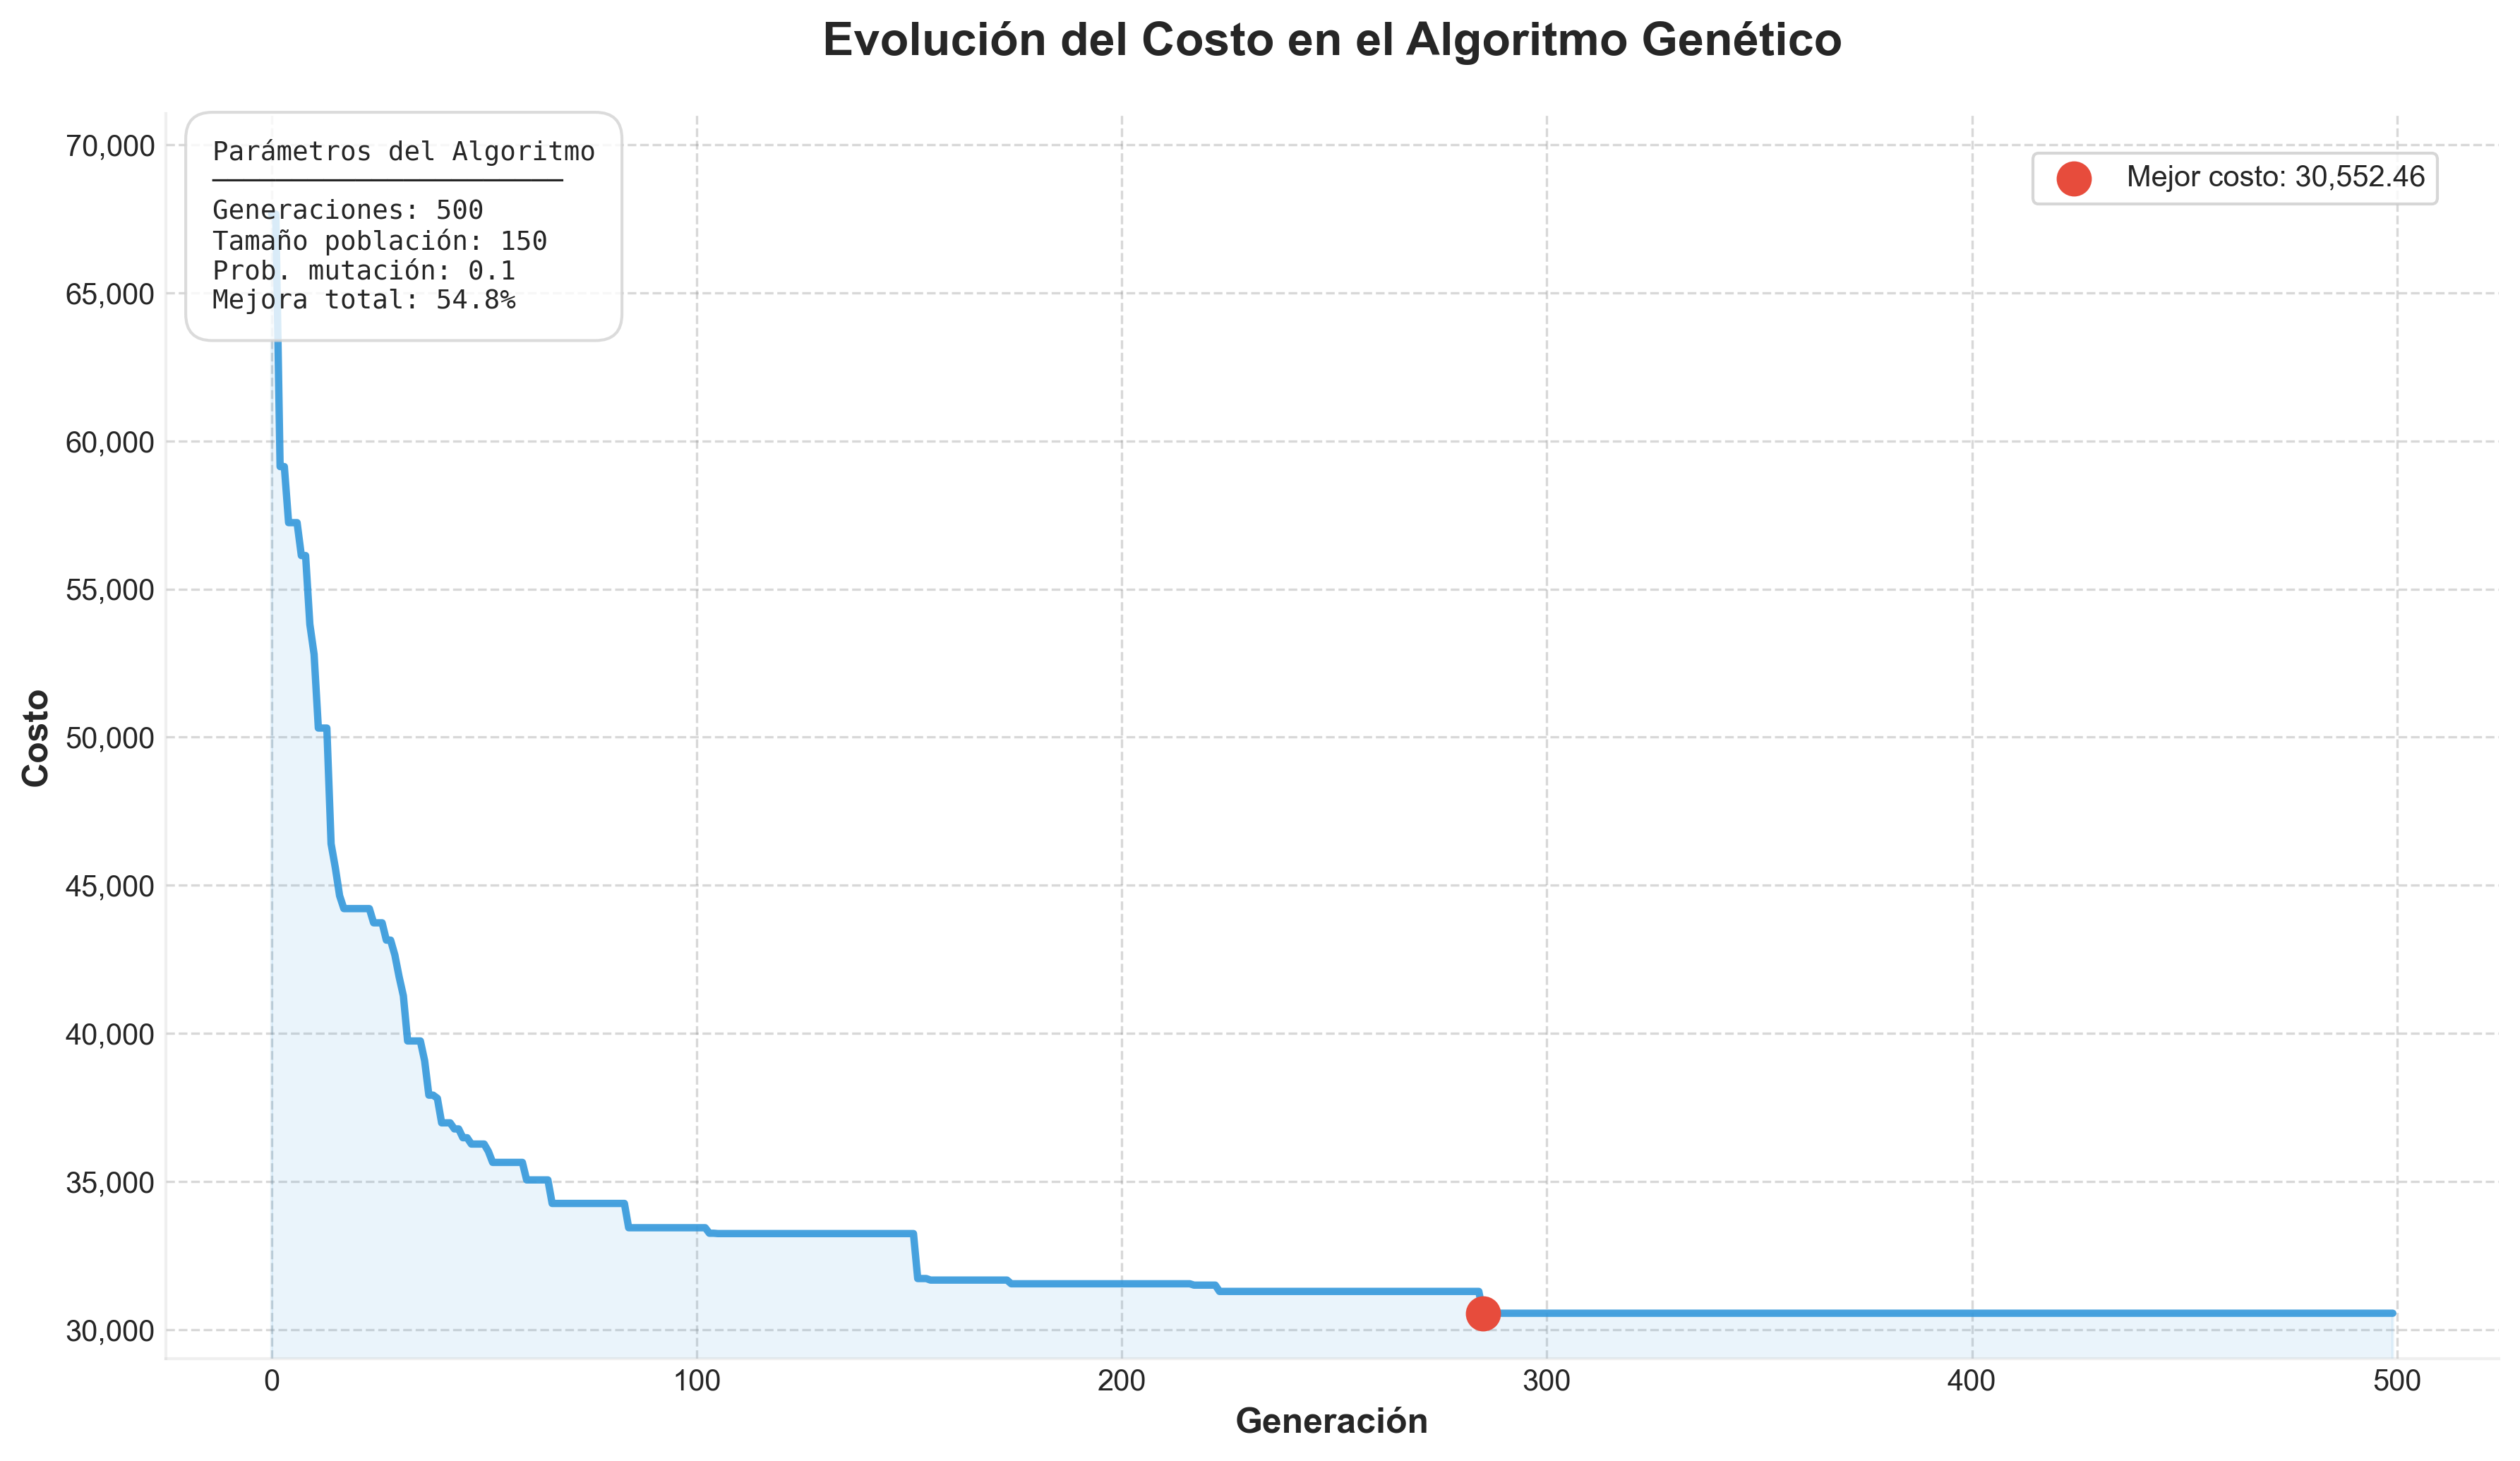

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ga_evolution(evolucion_costos, mejor_costo_ga, num_generaciones, tamano_poblacion, prob_mutacion):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos para la gráfica
    iterations = np.arange(len(evolucion_costos))
    
    # Crear el gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, evolucion_costos, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Añadir área sombreada bajo la curva
    ax.fill_between(iterations, 
                   evolucion_costos, 
                   color=main_color, 
                   alpha=0.1)
    
    # Encontrar la generación donde se encontró el mejor costo
    idx_mejor_costo = evolucion_costos.index(min(evolucion_costos))
    
    # Marcar el mejor costo
    ax.scatter(idx_mejor_costo, 
              mejor_costo_ga,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo_ga:,.2f}')
    
    # Personalizar el grid
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configurar los ejes
    ax.set_xlabel('Generación', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar los bordes del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Formatear los números del eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajustar los límites del eje Y
    ymin = min(evolucion_costos) * 0.95
    ymax = max(evolucion_costos) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título principal
    plt.title('Evolución del Costo en el Algoritmo Genético', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Crear cuadro de texto para los parámetros
    mejora_total = ((evolucion_costos[0] - mejor_costo_ga) / evolucion_costos[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Generaciones: {num_generaciones}\n'
        f'Tamaño población: {tamano_poblacion}\n'
        f'Prob. mutación: {prob_mutacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir el cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    # Guardar con alta calidad
    plt.savefig('evolucion_costos_ga_ferry.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Para usar la función:
plot_ga_evolution(
    evolucion_costos,
    mejor_costo_ga,
    num_generaciones=GENERACIONES,  # Reemplazar con tu valor
    tamano_poblacion=POBLACION,  # Reemplazar con tu valor
    prob_mutacion=MUTACION      # Reemplazar con tu valor
)

In [22]:
import folium
from IPython.display import display

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Dibujar líneas entre las ciudades
for i in range(len(coordenadas_ruta) - 1):
    puntos = [coordenadas_ruta[i], coordenadas_ruta[i + 1]]
    folium.PolyLine(
        puntos,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(mapa)

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(
            location=(lat, lon),
            popup=f"Inicio/Final: {mejor_ruta[i]}", 
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(
            location=(lat, lon),
            popup=f"Penúltima parada: {mejor_ruta[i]}", 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(
            location=(lat, lon),
            popup=f"Intermedia: {mejor_ruta[i]}", 
            icon=folium.Icon(color="blue")
        ).add_to(mapa)
        

# Construir la ruta relativa para guardar el archivo
ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_ferry_ga.html"))

# Crear las carpetas necesarias si no existen
os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

# Guardar el archivo HTML
mapa.save(ruta_guardar)

# Mostrar el mapa en la visualización
display(mapa)

In [23]:
import openrouteservice
import folium
from IPython.display import display

# Crear cliente de Open Route Service
api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
client = openrouteservice.Client(key=api_key)

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Dividir la ruta en segmentos
segmentos = [(coordenadas_ruta[i], coordenadas_ruta[i + 1]) for i in range(len(coordenadas_ruta) - 1)]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Obtener y graficar cada segmento
for inicio, fin in segmentos:
    try:
        # Solicitar la ruta para el segmento actual
        route = client.directions(
            coordinates=[(inicio[1], inicio[0]), (fin[1], fin[0])],
            profile='driving-car',
            format='geojson'
        )
        # Agregar el segmento al mapa
        folium.GeoJson(route, name="Segmento").add_to(mapa)
    except Exception as e:
        print(f"Error al procesar segmento {inicio} -> {fin}: {e}")

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(location=(lat, lon), 
                     popup=f"Inicio/Final: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="green", icon="info-sign")).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(location=(lat, lon), 
                     popup=f"Penúltima parada: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="red", icon="info-sign")).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(location=(lat, lon), 
                     popup=f"Intermedia: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="blue")).add_to(mapa)



ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_con_api_ferry_ga.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)


# Guardar el mapa como HTML
mapa.save(ruta_guardar)

# Mostrar el mapa
display(mapa)

c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: U

## 31 Estados

In [24]:
ciudades = [
    'Chilpancingo, Guerrero',
    'Cuernavaca, Morelos',
    'Ciudad de México, Ciudad de México',
    'Pachuca, Hidalgo',
    'Puebla, Puebla',
    'Tlaxcala, Tlaxcala',
    'Morelia, Michoacán',
    'Querétaro, Querétaro',
    'San Luis Potosí, San Luis Potosí',
    'Guanajuato, Guanajuato',
    'Aguascalientes, Aguascalientes',
    'Zacatecas, Zacatecas',
    'Durango, Durango',
    'Culiacán, Sinaloa',
    'Hermosillo, Sonora',
    'Mexicali, Baja California',
    'Colima, Colima',
    'Guadalajara, Jalisco',
    'Tepic, Nayarit',
    'Chihuahua, Chihuahua',
    'Monterrey, Nuevo León',
    'Ciudad Victoria, Tamaulipas',
    'Saltillo, Coahuila',
    'Oaxaca de Juárez, Oaxaca',
    'Xalapa, Veracruz',
    'Villahermosa, Tabasco',
    'Campeche, Campeche',
    'Mérida, Yucatán',
    'Chetumal, Quintana Roo',
    'Tuxtla Gutiérrez, Chiapas',
    'Toluca, Estado de México'
]

In [25]:
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

In [26]:
distancias = pd.read_csv("../costos/tabla_distancias.csv", index_col=0)  # Tabla de distancias (km)
tiempos = pd.read_csv("../costos/tabla_tiempos.csv", index_col=0)        # Tabla de tiempos (horas)
peajes = pd.read_excel("../costos/peajes.xlsx", index_col=0)  # Tabla de costos de peajes (MXN)

# Eliminar la fila y columna llamada "La Paz"
distancias = distancias.drop(index="La Paz", columns="La Paz")
tiempos = tiempos.drop(index="La Paz", columns="La Paz")
peajes = peajes.drop(index="La Paz", columns="La Paz")


In [27]:
def convertir_a_minutos(tiempo):
    if pd.isna(tiempo):
        return np.nan
    horas, minutos = map(int, str(tiempo).split(':'))
    return horas * 60 + minutos

tiempos_minutos = tiempos.map(convertir_a_minutos)

print("Tiempos convertidos a minutos satisfactoriamente.")

Tiempos convertidos a minutos satisfactoriamente.


In [28]:
num_ciudades = distancias.shape[0]
costos = np.zeros((num_ciudades, num_ciudades))

for i in range(num_ciudades):
    for j in range(num_ciudades):
        if i != j:  # Evitar costos para una ciudad hacia sí misma
            distancia = distancias.iloc[i, j]
            tiempo = tiempos_minutos.iloc[i, j] / 60
            peaje = peajes.iloc[i, j]

            costo_combustible = (distancia / RENDIMIENTO_AUTO) * COSTO_COMBUSTIBLE
            costo_tiempo = tiempo * VALOR_HORA

            costos[i, j] = costo_combustible + costo_tiempo + peaje

matriz_costos = pd.DataFrame(costos, index=distancias.index, columns=distancias.columns)

matriz_costos.to_excel("matriz_costos_31.xlsx")

print("Matriz de costos calculada y guardada en 'matriz_costos.xlsx'")

Matriz de costos calculada y guardada en 'matriz_costos.xlsx'


In [29]:
GENERACIONES = 500
POBLACION = 150
MUTACION = 0.1

In [30]:
matriz_costos = pd.read_excel("matriz_costos_31.xlsx", index_col=0)
ciudades = matriz_costos.index

In [31]:
np.random.seed(42)


# Ejecutar el algoritmo genético
GENERACIONES = 500
POBLACION = 150
MUTACION = 0.1
ciudades = list(coordenadas.keys())

mejor_ruta, mejor_costo_ga, evolucion_costos = algoritmo_genetico(
    matriz_costos, ciudades, GENERACIONES, POBLACION, MUTACION
)

print("Mejor ruta encontrada por GA:", mejor_ruta)
print("Costo total:", mejor_costo_ga)

Mejor ruta encontrada por GA: ['Saltillo', 'Monterrey', 'Ciudad Victoria', 'San Luis Potosí', 'Santiago de Querétaro', 'Morelia', 'Guanajuato', 'Zacatecas', 'Aguascalientes', 'Tepic', 'Guadalajara', 'Colima', 'Toluca de Lerdo', 'CDMX', 'Cuernavaca', 'Chilpancingo de los Bravo', 'Heroica Puebla de Zaragoza', 'Tlaxcala de Xicohténcatl', 'Oaxaca de Juárez', 'Tuxtla Gutiérrez', 'Villahermosa', 'San Francisco de Campeche', 'Mérida', 'Chetumal', 'Xalapa-Enríquez', 'Pachuca de Soto', 'Victoria de Durango', 'Culiacán Rosales', 'Hermosillo', 'Mexicali', 'Chihuahua', 'Saltillo']
Costo total: 30044.31585306911


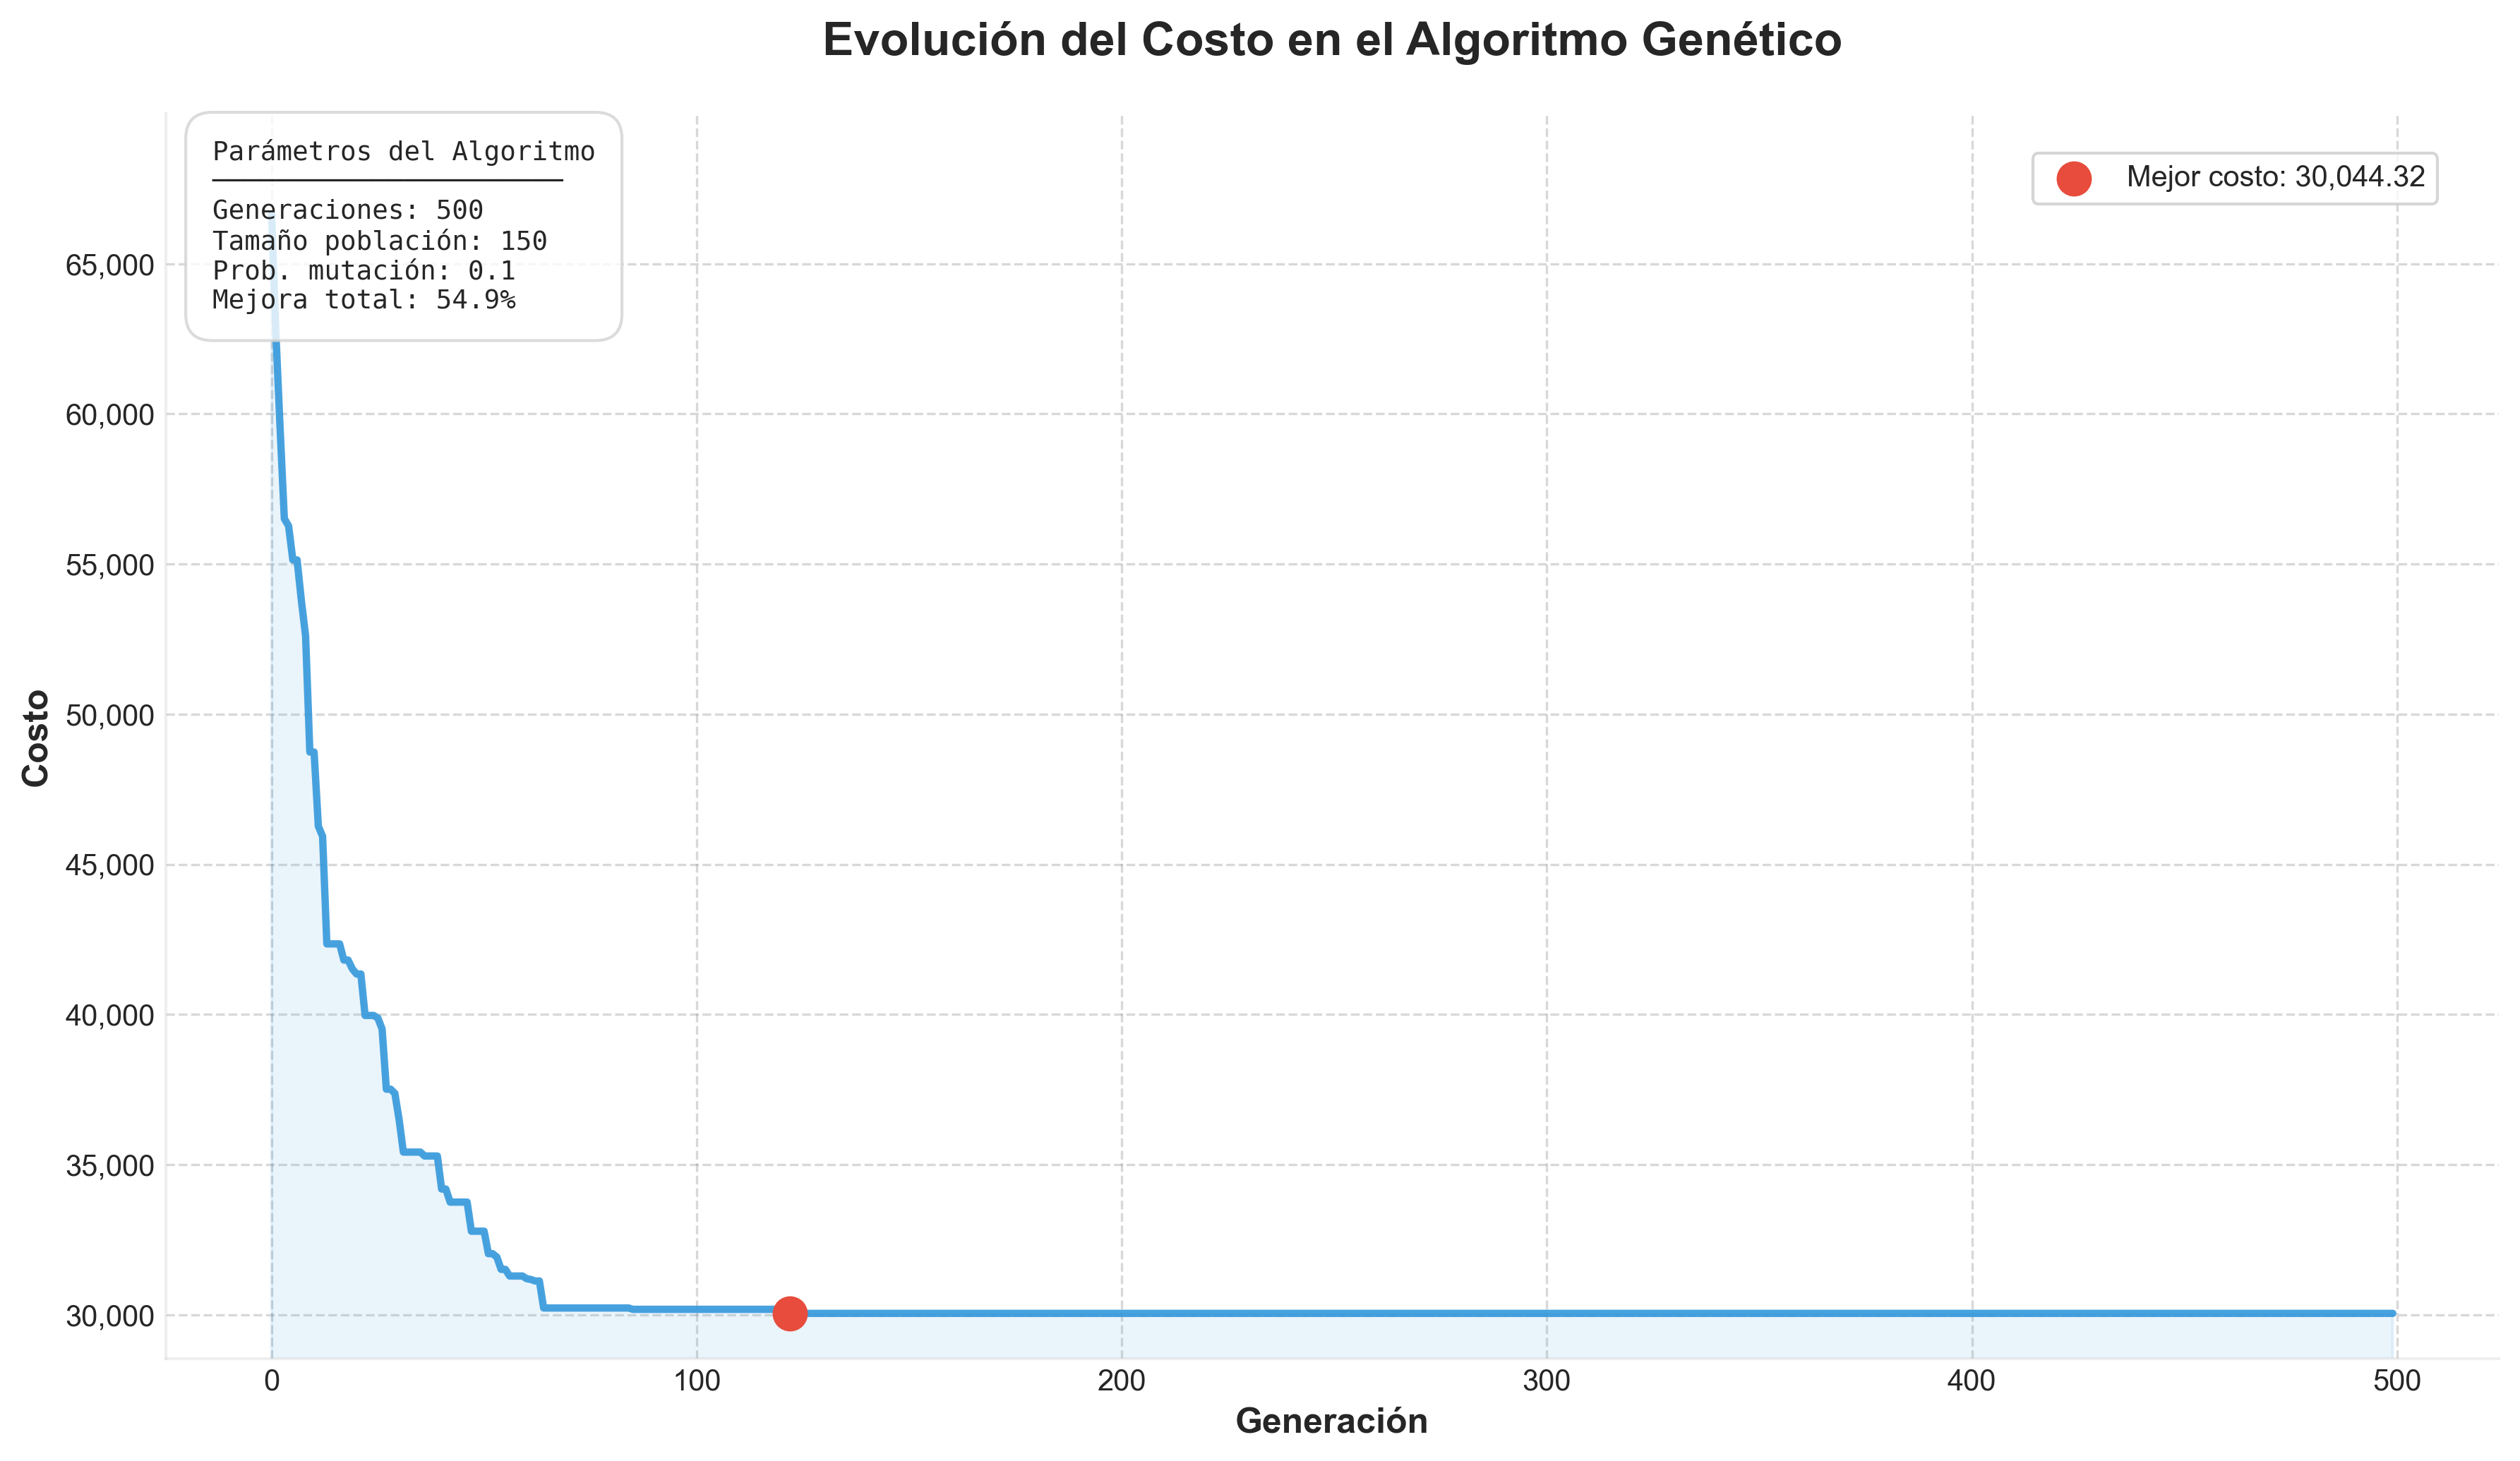

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ga_evolution(evolucion_costos, mejor_costo_ga, num_generaciones, tamano_poblacion, prob_mutacion):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear figura con fondo blanco
    fig, ax = plt.subplots(figsize=(12, 7), dpi=300, facecolor='white')
    ax.set_facecolor('white')
    
    # Procesar datos para la gráfica
    iterations = np.arange(len(evolucion_costos))
    
    # Crear el gráfico principal
    main_color = '#3498db'
    ax.plot(iterations, evolucion_costos, 
            color=main_color, 
            linewidth=2.5,
            alpha=0.9)
    
    # Añadir área sombreada bajo la curva
    ax.fill_between(iterations, 
                   evolucion_costos, 
                   color=main_color, 
                   alpha=0.1)
    
    # Encontrar la generación donde se encontró el mejor costo
    idx_mejor_costo = evolucion_costos.index(min(evolucion_costos))
    
    # Marcar el mejor costo
    ax.scatter(idx_mejor_costo, 
              mejor_costo_ga,
              color='#e74c3c', 
              s=120, 
              zorder=5,
              label=f'Mejor costo: {mejor_costo_ga:,.2f}')
    
    # Personalizar el grid
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Configurar los ejes
    ax.set_xlabel('Generación', fontsize=12, fontweight='bold')
    ax.set_ylabel('Costo', fontsize=12, fontweight='bold')
    
    # Eliminar los bordes del gráfico
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_alpha(0.3)
    
    # Formatear los números del eje Y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Ajustar los límites del eje Y
    ymin = min(evolucion_costos) * 0.95
    ymax = max(evolucion_costos) * 1.05
    ax.set_ylim(ymin, ymax)
    
    # Título principal
    plt.title('Evolución del Costo en el Algoritmo Genético', 
             fontsize=16, 
             fontweight='bold', 
             pad=20)
    
    # Crear cuadro de texto para los parámetros
    mejora_total = ((evolucion_costos[0] - mejor_costo_ga) / evolucion_costos[0] * 100)
    param_text = (
        'Parámetros del Algoritmo\n'
        '──────────────────────\n'
        f'Generaciones: {num_generaciones}\n'
        f'Tamaño población: {tamano_poblacion}\n'
        f'Prob. mutación: {prob_mutacion}\n'
        f'Mejora total: {mejora_total:.1f}%'
    )
    
    # Añadir el cuadro de texto
    plt.text(0.02, 0.98, param_text,
             transform=ax.transAxes,
             fontsize=9,
             fontfamily='monospace',
             bbox=dict(facecolor='white',
                      edgecolor='lightgray',
                      alpha=0.8,
                      pad=10,
                      boxstyle='round,pad=1'),
             verticalalignment='top')
    
    # Leyenda
    legend = ax.legend(frameon=True,
                      framealpha=0.9,
                      fontsize=10,
                      loc='upper right',
                      bbox_to_anchor=(0.98, 0.98))
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.8)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    # Guardar con alta calidad
    plt.savefig('evolucion_costos_ga.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    
    plt.show()

# Para usar la función:
plot_ga_evolution(
    evolucion_costos,
    mejor_costo_ga,
    num_generaciones=GENERACIONES,  # Reemplazar con tu valor
    tamano_poblacion=POBLACION,  # Reemplazar con tu valor
    prob_mutacion=MUTACION      # Reemplazar con tu valor
)

In [33]:
import folium
from IPython.display import display

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Dibujar líneas entre las ciudades
for i in range(len(coordenadas_ruta) - 1):
    puntos = [coordenadas_ruta[i], coordenadas_ruta[i + 1]]
    folium.PolyLine(
        puntos,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(mapa)

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(
            location=(lat, lon),
            popup=f"Inicio/Final: {mejor_ruta[i]}", 
            icon=folium.Icon(color="green", icon="info-sign")
        ).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(
            location=(lat, lon),
            popup=f"Penúltima parada: {mejor_ruta[i]}", 
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(
            location=(lat, lon),
            popup=f"Intermedia: {mejor_ruta[i]}", 
            icon=folium.Icon(color="blue")
        ).add_to(mapa)

ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_ga_31.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)

mapa.save(ruta_guardar)

# Mostrar el mapa en la visualización
display(mapa)

In [ ]:
import openrouteservice
import folium
from IPython.display import display

# Crear cliente de Open Route Service
api_key = "5b3ce3597851110001cf6248c140bc578aac4c2d95295dc798e53a22"
client = openrouteservice.Client(key=api_key)

# Diccionario con las coordenadas de las ciudades
coordenadas = {
    "Aguascalientes": (21.8833, -102.2833),
    "Mexicali": (32.5333, -117.0167),
    "La Paz": (24.1444, -110.3000),
    "San Francisco de Campeche": (19.8439, -90.5253),
    "Tuxtla Gutiérrez": (16.7531, -93.1167),
    "Chihuahua": (28.6353, -106.0894),
    "CDMX": (19.4326, -99.1332),
    "Saltillo": (25.4383, -100.9833),
    "Colima": (19.2433, -103.7250),
    "Victoria de Durango": (24.0228, -104.6532),
    "Guanajuato": (21.0169, -101.2591),
    "Chilpancingo de los Bravo": (17.5506, -99.5058),
    "Pachuca de Soto": (20.1167, -98.7333),
    "Guadalajara": (20.6767, -103.3476),
    "Toluca de Lerdo": (19.2922, -99.6672),
    "Morelia": (19.7008, -101.1860),
    "Cuernavaca": (18.9167, -99.25),
    "Tepic": (21.5083, -104.8950),
    "Monterrey": (25.6866, -100.3161),
    "Oaxaca de Juárez": (17.06, -96.7216),
    "Heroica Puebla de Zaragoza": (19.0413, -98.2062),
    "Santiago de Querétaro": (20.5888, -100.3899),
    "Chetumal": (18.5000, -88.3000),
    "San Luis Potosí": (22.1565, -100.9855),
    "Culiacán Rosales": (24.8083, -107.3939),
    "Hermosillo": (29.0729, -110.9559),
    "Villahermosa": (17.9892, -92.9291),
    "Ciudad Victoria": (24.2669, -98.8363),
    "Tlaxcala de Xicohténcatl": (19.3139, -98.2419),
    "Xalapa-Enríquez": (19.1738, -96.1342),
    "Mérida": (20.9667, -89.6167),
    "Zacatecas": (22.7709, -102.5833)
}

# Convertir la ruta a coordenadas
coordenadas_ruta = [coordenadas[ciudad] for ciudad in mejor_ruta]

# Dividir la ruta en segmentos
segmentos = [(coordenadas_ruta[i], coordenadas_ruta[i + 1]) for i in range(len(coordenadas_ruta) - 1)]

# Crear el mapa
mapa = folium.Map(location=coordenadas_ruta[0], zoom_start=6)

# Obtener y graficar cada segmento
for inicio, fin in segmentos:
    try:
        # Solicitar la ruta para el segmento actual
        route = client.directions(
            coordinates=[(inicio[1], inicio[0]), (fin[1], fin[0])],
            profile='driving-car',
            format='geojson'
        )
        # Agregar el segmento al mapa
        folium.GeoJson(route, name="Segmento").add_to(mapa)
    except Exception as e:
        print(f"Error al procesar segmento {inicio} -> {fin}: {e}")

# Agregar marcadores para inicio/final, penúltima ciudad y ciudades intermedias
for i, (lat, lon) in enumerate(coordenadas_ruta):
    if i == 0 or i == len(coordenadas_ruta) - 1:  # Primera y última ciudad (mismo lugar)
        folium.Marker(location=(lat, lon), 
                     popup=f"Inicio/Final: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="green", icon="info-sign")).add_to(mapa)
    elif i == len(coordenadas_ruta) - 2:  # Penúltima ciudad
        folium.Marker(location=(lat, lon), 
                     popup=f"Penúltima parada: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="red", icon="info-sign")).add_to(mapa)
    else:  # Ciudades intermedias
        folium.Marker(location=(lat, lon), 
                     popup=f"Intermedia: {mejor_ruta[i]}", 
                     icon=folium.Icon(color="blue")).add_to(mapa)


ruta_guardar = os.path.abspath(os.path.join(ruta_base, "./html/hormigas/ruta_ciudades_31_ga_con_api.html"))

os.makedirs(os.path.dirname(ruta_guardar), exist_ok=True)



# Guardar el mapa como HTML
mapa.save(ruta_guardar)

# Mostrar el mapa
display(mapa)

c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 1st time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 2nd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 3rd time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: UserWarning: Rate limit exceeded. Retrying for the 4th time.
  warnings.warn('Rate limit exceeded. Retrying for the {0}{1} time.'.format(retry_counter + 1,
c:\Users\57320\anaconda3\Lib\site-packages\openrouteservice\client.py:211: U